#### Imports

In [1]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

import os

Using TensorFlow backend.


In [2]:
# pip install librosa

#### Reading the dataframe with file ids and class labels

In [3]:
data = pd.read_csv('./train/data.csv')

In [214]:
data

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
...,...,...
5430,8725,engine_idling
5431,8726,dog_bark
5432,8727,engine_idling
5433,8728,engine_idling


#### Reading a random audio file to listen to it

In [51]:
i = random.choice(data.ID)
i=132
ipd.Audio('train/Train/'+str(i)+'.wav')

#### Research showed the most important features we can extract from an audio file using librosa which is a great python library for audio 

![librosa_features](img/librosa_features.jpg)

#### Function to extract the most common audio features from librosa for each sound file. We also added the class label at the end

In [75]:
# Although this function was modified and many parameteres were explored with, most of it 
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('train/Train')+'/'+str(files.ID)+'.wav')

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.Class

    return mfccs, chroma, mel, contrast, tonnetz, label

In [76]:
# Applying the function to the train data by accessing each row of the dataframe
features_labels = data.apply(extract_features, axis=1)

#### We get 4 arrays of numbers, one for each feature

In [77]:
features_labels

0       ([-82.12359, 139.50595, -42.430847, 24.82786, ...
1       ([-15.744001, 124.11996, -29.42888, 39.44719, ...
2       ([-123.393654, 15.181944, -50.093338, 7.141871...
3       ([-213.2787, 89.323616, -55.256165, 12.632097,...
4       ([-237.9265, 135.90247, 39.26844, 21.24023, 9....
                              ...                        
5430    ([-214.65845, 178.94125, -1.2636195, 63.962276...
5431    ([-395.34586, 105.81336, -0.19628958, -7.09791...
5432    ([-320.81738, 58.30057, -6.869504, 15.693741, ...
5433    ([-277.0318, 141.1457, -36.32912, 39.455746, -...
5434    ([-290.99677, 233.35152, -4.6723485, 4.6523285...
Length: 5435, dtype: object

In [141]:
# It takes a long time to extract those features from the files so we will save the results 
# in a dataframe to be able to access them if needed
features_df = pd.DataFrame(features_labels)
features_df.to_csv('features_df.csv', index=False)

In [78]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_labels)):
    features.append(np.concatenate((features_labels[i][0], features_labels[i][1], 
                features_labels[i][2], features_labels[i][3],
                features_labels[i][4]), axis=0))

In [80]:
len(features)

5435

In [81]:
# Similarly, we create a list where we will store all the labels

labels = []
for i in range(0, len(features_labels)):
    labels.append(features_labels[i][5])

In [82]:
len(labels)

5435

In [221]:
# to let me know when it's done
os.system('say -v Juan ya acabé');

#### Checking if we have balanced classes

In [84]:
np.unique(labels, return_counts=True)

(array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
        'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
        'street_music'], dtype='<U16'),
 array([600, 306, 600, 600, 600, 624, 230, 668, 607, 600]))

#### Hot encoding y and pre processing X and y

In [85]:
# Setting our X as a numpy array to feed into the neural network
X = np.array(features)

In [86]:
# Setting our y
y = np.array(labels)

In [87]:
y

array(['siren', 'street_music', 'drilling', ..., 'engine_idling',
       'engine_idling', 'air_conditioner'], dtype='<U16')

In [88]:
# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [89]:
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [90]:
# Checking our shapes
X.shape

(5435, 193)

In [91]:
# Checking our shapes
y.shape

(5435, 10)

In [92]:
# Choosing the first 3435 files to be our train data
# Choosing the next 1000 files to be our validation data
# Choosing the next 1000 files to be our test never before seen data
# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series

X_train = X[:3435]
y_train = y[:3435]

X_val = X[3435:4435]
y_val = y[3435:4435]

X_test = X[4435:]
y_test = y[4435:]

We need to make sure that our splits still contain the proportion of our classes, either balanced or unbalanced (analogous to stratify)

In [93]:
data[:3435]['Class'].value_counts(normalize=True)

jackhammer          0.125182
street_music        0.114410
siren               0.113537
air_conditioner     0.112955
engine_idling       0.112082
drilling            0.109170
dog_bark            0.108006
children_playing    0.106841
car_horn            0.053566
gun_shot            0.044250
Name: Class, dtype: float64

In [94]:
data[3435:4435]['Class'].value_counts(normalize=True)

children_playing    0.131
jackhammer          0.126
engine_idling       0.118
air_conditioner     0.113
dog_bark            0.109
siren               0.104
drilling            0.103
street_music        0.101
car_horn            0.054
gun_shot            0.041
Name: Class, dtype: float64

In [95]:
data[4435:]['Class'].value_counts(normalize=True)

drilling            0.122
engine_idling       0.121
dog_bark            0.120
siren               0.113
jackhammer          0.112
street_music        0.106
children_playing    0.102
air_conditioner     0.099
car_horn            0.068
gun_shot            0.037
Name: Class, dtype: float64

Checking the shapes, making sure everything is in order

In [96]:
X_train.shape

(3435, 193)

In [97]:
y_train.shape

(3435, 10)

In [98]:
X_val.shape

(1000, 193)

In [99]:
y_val.shape

(1000, 10)

We need to scale all our X splits to have better results

In [102]:
# Scaling
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [217]:
from datetime import datetime
startTime = datetime.now()

#### Grid searching over the neural network to find best parameters

In [ ]:
def model_func(layer_one_neurons=128, layer_one_dropout=.5, layer_two_neurons=512, 
               layer_two_dropout=.5, layer_three_neurons=128, layer_three_dropout=.5):
    
    model = Sequential()
    
    model.add(Dense(layer_one_neurons,
                    input_shape=(193,),
                          activation='relu'))
    
    model.add(Dropout(layer_one_dropout))
    
    model.add(Dense(layer_two_neurons,
                    activation='relu'))
    
    model.add(Dropout(layer_two_dropout))

    model.add(Dense(layer_three_neurons,
                    activation='relu'))

    model.add(Dropout(layer_three_dropout))

    model.add(Dense(10,
                    activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model


nn = KerasRegressor(model_func, batch_size=512, verbose=2)

params = {
    'epochs': [100],
    'layer_one_neurons': [193],
    'layer_two_neurons': [64, 128],
    'layer_three_neurons': [128, 256],
    'layer_one_dropout': [.25,.5],
    'layer_two_dropout': [.5,.75],
    'layer_three_dropout': [.5,.75]
}
gs = GridSearchCV(nn, param_grid=params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

Epoch 1/100
 - 0s - loss: 2.5493 - accuracy: 0.1044
Epoch 2/100
 - 0s - loss: 2.3498 - accuracy: 0.1493
Epoch 3/100
 - 0s - loss: 2.2446 - accuracy: 0.1694
Epoch 4/100
 - 0s - loss: 2.1466 - accuracy: 0.2223
Epoch 5/100
 - 0s - loss: 2.0944 - accuracy: 0.2633
Epoch 6/100
 - 0s - loss: 2.0150 - accuracy: 0.2782
Epoch 7/100
 - 0s - loss: 1.9451 - accuracy: 0.2965
Epoch 8/100
 - 0s - loss: 1.9051 - accuracy: 0.3249
Epoch 9/100
 - 0s - loss: 1.8587 - accuracy: 0.3323
Epoch 10/100
 - 0s - loss: 1.7728 - accuracy: 0.3603
Epoch 11/100
 - 0s - loss: 1.7624 - accuracy: 0.3782
Epoch 12/100
 - 0s - loss: 1.6479 - accuracy: 0.4135
Epoch 13/100
 - 0s - loss: 1.6063 - accuracy: 0.4236
Epoch 14/100
 - 0s - loss: 1.5515 - accuracy: 0.4498
Epoch 15/100
 - 0s - loss: 1.5067 - accuracy: 0.4672
Epoch 16/100
 - 0s - loss: 1.4649 - accuracy: 0.4852
Epoch 17/100
 - 0s - loss: 1.4354 - accuracy: 0.4873
Epoch 18/100
 - 0s - loss: 1.3569 - accuracy: 0.5288
Epoch 19/100
 - 0s - loss: 1.3231 - accuracy: 0.5498
Ep

Epoch 56/100
 - 0s - loss: 0.5557 - accuracy: 0.8253
Epoch 57/100
 - 0s - loss: 0.5533 - accuracy: 0.8245
Epoch 58/100
 - 0s - loss: 0.5628 - accuracy: 0.8210
Epoch 59/100
 - 0s - loss: 0.5581 - accuracy: 0.8183
Epoch 60/100
 - 0s - loss: 0.5315 - accuracy: 0.8293
Epoch 61/100
 - 0s - loss: 0.5165 - accuracy: 0.8262
Epoch 62/100
 - 0s - loss: 0.5110 - accuracy: 0.8432
Epoch 63/100
 - 0s - loss: 0.4957 - accuracy: 0.8424
Epoch 64/100
 - 0s - loss: 0.4834 - accuracy: 0.8485
Epoch 65/100
 - 0s - loss: 0.4631 - accuracy: 0.8493
Epoch 66/100
 - 0s - loss: 0.4824 - accuracy: 0.8541
Epoch 67/100
 - 0s - loss: 0.4624 - accuracy: 0.8472
Epoch 68/100
 - 0s - loss: 0.4472 - accuracy: 0.8515
Epoch 69/100
 - 0s - loss: 0.4660 - accuracy: 0.8515
Epoch 70/100
 - 0s - loss: 0.4651 - accuracy: 0.8568
Epoch 71/100
 - 0s - loss: 0.4257 - accuracy: 0.8638
Epoch 72/100
 - 0s - loss: 0.4226 - accuracy: 0.8620
Epoch 73/100
 - 0s - loss: 0.4151 - accuracy: 0.8751
Epoch 74/100
 - 0s - loss: 0.4420 - accuracy: 

Epoch 11/100
 - 0s - loss: 1.5915 - accuracy: 0.4463
Epoch 12/100
 - 0s - loss: 1.4984 - accuracy: 0.4795
Epoch 13/100
 - 0s - loss: 1.4587 - accuracy: 0.5087
Epoch 14/100
 - 0s - loss: 1.3667 - accuracy: 0.5306
Epoch 15/100
 - 0s - loss: 1.3191 - accuracy: 0.5493
Epoch 16/100
 - 0s - loss: 1.2717 - accuracy: 0.5672
Epoch 17/100
 - 0s - loss: 1.2058 - accuracy: 0.5843
Epoch 18/100
 - 0s - loss: 1.1724 - accuracy: 0.6096
Epoch 19/100
 - 0s - loss: 1.1236 - accuracy: 0.6131
Epoch 20/100
 - 0s - loss: 1.0762 - accuracy: 0.6568
Epoch 21/100
 - 0s - loss: 1.0504 - accuracy: 0.6559
Epoch 22/100
 - 0s - loss: 1.0165 - accuracy: 0.6642
Epoch 23/100
 - 0s - loss: 1.0372 - accuracy: 0.6537
Epoch 24/100
 - 0s - loss: 0.9671 - accuracy: 0.6886
Epoch 25/100
 - 0s - loss: 0.9513 - accuracy: 0.6996
Epoch 26/100
 - 0s - loss: 0.8957 - accuracy: 0.7083
Epoch 27/100
 - 0s - loss: 0.8534 - accuracy: 0.7197
Epoch 28/100
 - 0s - loss: 0.8447 - accuracy: 0.7371
Epoch 29/100
 - 0s - loss: 0.8070 - accuracy: 

Epoch 66/100
 - 0s - loss: 0.3162 - accuracy: 0.8987
Epoch 67/100
 - 0s - loss: 0.3390 - accuracy: 0.8891
Epoch 68/100
 - 0s - loss: 0.3104 - accuracy: 0.9000
Epoch 69/100
 - 0s - loss: 0.3094 - accuracy: 0.9026
Epoch 70/100
 - 0s - loss: 0.2921 - accuracy: 0.9074
Epoch 71/100
 - 0s - loss: 0.2832 - accuracy: 0.9140
Epoch 72/100
 - 0s - loss: 0.2905 - accuracy: 0.9100
Epoch 73/100
 - 0s - loss: 0.3014 - accuracy: 0.9092
Epoch 74/100
 - 0s - loss: 0.2865 - accuracy: 0.9052
Epoch 75/100
 - 0s - loss: 0.2534 - accuracy: 0.9205
Epoch 76/100
 - 0s - loss: 0.2667 - accuracy: 0.9179
Epoch 77/100
 - 0s - loss: 0.2576 - accuracy: 0.9231
Epoch 78/100
 - 0s - loss: 0.2897 - accuracy: 0.9096
Epoch 79/100
 - 0s - loss: 0.2688 - accuracy: 0.9092
Epoch 80/100
 - 0s - loss: 0.2612 - accuracy: 0.9218
Epoch 81/100
 - 0s - loss: 0.2561 - accuracy: 0.9170
Epoch 82/100
 - 0s - loss: 0.2440 - accuracy: 0.9210
Epoch 83/100
 - 0s - loss: 0.2647 - accuracy: 0.9201
Epoch 84/100
 - 0s - loss: 0.2577 - accuracy: 

Epoch 21/100
 - 0s - loss: 1.7504 - accuracy: 0.3664
Epoch 22/100
 - 0s - loss: 1.7379 - accuracy: 0.3790
Epoch 23/100
 - 0s - loss: 1.7144 - accuracy: 0.3747
Epoch 24/100
 - 0s - loss: 1.6653 - accuracy: 0.4000
Epoch 25/100
 - 0s - loss: 1.6748 - accuracy: 0.3908
Epoch 26/100
 - 0s - loss: 1.6437 - accuracy: 0.4183
Epoch 27/100
 - 0s - loss: 1.6256 - accuracy: 0.4192
Epoch 28/100
 - 0s - loss: 1.5940 - accuracy: 0.4284
Epoch 29/100
 - 0s - loss: 1.5972 - accuracy: 0.4384
Epoch 30/100
 - 0s - loss: 1.5272 - accuracy: 0.4428
Epoch 31/100
 - 0s - loss: 1.5454 - accuracy: 0.4533
Epoch 32/100
 - 0s - loss: 1.5266 - accuracy: 0.4555
Epoch 33/100
 - 0s - loss: 1.4852 - accuracy: 0.4799
Epoch 34/100
 - 0s - loss: 1.4842 - accuracy: 0.4782
Epoch 35/100
 - 0s - loss: 1.4361 - accuracy: 0.5044
Epoch 36/100
 - 0s - loss: 1.4359 - accuracy: 0.4847
Epoch 37/100
 - 0s - loss: 1.4156 - accuracy: 0.5044
Epoch 38/100
 - 0s - loss: 1.4258 - accuracy: 0.5061
Epoch 39/100
 - 0s - loss: 1.3966 - accuracy: 

Epoch 76/100
 - 0s - loss: 0.8876 - accuracy: 0.6917
Epoch 77/100
 - 0s - loss: 0.8834 - accuracy: 0.6838
Epoch 78/100
 - 0s - loss: 0.8703 - accuracy: 0.7070
Epoch 79/100
 - 0s - loss: 0.8466 - accuracy: 0.7044
Epoch 80/100
 - 0s - loss: 0.8237 - accuracy: 0.7092
Epoch 81/100
 - 0s - loss: 0.8381 - accuracy: 0.7013
Epoch 82/100
 - 0s - loss: 0.8435 - accuracy: 0.7122
Epoch 83/100
 - 0s - loss: 0.8308 - accuracy: 0.7087
Epoch 84/100
 - 0s - loss: 0.8100 - accuracy: 0.7092
Epoch 85/100
 - 0s - loss: 0.8184 - accuracy: 0.7127
Epoch 86/100
 - 0s - loss: 0.8097 - accuracy: 0.7183
Epoch 87/100
 - 0s - loss: 0.8080 - accuracy: 0.7100
Epoch 88/100
 - 0s - loss: 0.7947 - accuracy: 0.7197
Epoch 89/100
 - 0s - loss: 0.8026 - accuracy: 0.7197
Epoch 90/100
 - 0s - loss: 0.7954 - accuracy: 0.7122
Epoch 91/100
 - 0s - loss: 0.7704 - accuracy: 0.7367
Epoch 92/100
 - 0s - loss: 0.7526 - accuracy: 0.7376
Epoch 93/100
 - 0s - loss: 0.7931 - accuracy: 0.7262
Epoch 94/100
 - 0s - loss: 0.7748 - accuracy: 

In [ ]:
print(datetime.now() - startTime)

In [ ]:
os.system('say -v Juan ya acabé');

#### Building the neural network using the best parameters

In [187]:
# build a simple dense model with early stopping with softmax for categorical classification
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [188]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 15
history = model.fit(X_train, y_train, batch_size=256, epochs=200, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])
                    

Train on 3435 samples, validate on 1000 samples
Epoch 1/200
3435/3435 [==============================] - 0s 102us/step - loss: 2.2507 - accuracy: 0.2079 - val_loss: 1.8942 - val_accuracy: 0.4440
Epoch 2/200
3435/3435 [==============================] - 0s 20us/step - loss: 1.8551 - accuracy: 0.3616 - val_loss: 1.5522 - val_accuracy: 0.5140
Epoch 3/200
3435/3435 [==============================] - 0s 19us/step - loss: 1.5470 - accuracy: 0.4783 - val_loss: 1.2783 - val_accuracy: 0.6070
Epoch 4/200
3435/3435 [==============================] - 0s 19us/step - loss: 1.3340 - accuracy: 0.5520 - val_loss: 1.0845 - val_accuracy: 0.7000
Epoch 5/200
3435/3435 [==============================] - 0s 20us/step - loss: 1.1418 - accuracy: 0.6221 - val_loss: 0.9458 - val_accuracy: 0.7310
Epoch 6/200
3435/3435 [==============================] - 0s 21us/step - loss: 0.9772 - accuracy: 0.6824 - val_loss: 0.8378 - val_accuracy: 0.7680
Epoch 7/200
3435/3435 [==============================] - 0s 19us/step - los

Epoch 112/200
3435/3435 [==============================] - 0s 19us/step - loss: 0.0262 - accuracy: 0.9936 - val_loss: 0.6201 - val_accuracy: 0.9210
Epoch 113/200
3435/3435 [==============================] - 0s 18us/step - loss: 0.0250 - accuracy: 0.9930 - val_loss: 0.6249 - val_accuracy: 0.9200
Epoch 114/200
3435/3435 [==============================] - 0s 17us/step - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.6305 - val_accuracy: 0.9200
Epoch 115/200
3435/3435 [==============================] - 0s 16us/step - loss: 0.0205 - accuracy: 0.9945 - val_loss: 0.6663 - val_accuracy: 0.9190
Epoch 116/200
3435/3435 [==============================] - 0s 18us/step - loss: 0.0240 - accuracy: 0.9945 - val_loss: 0.6876 - val_accuracy: 0.9130
Epoch 117/200
3435/3435 [==============================] - 0s 27us/step - loss: 0.0201 - accuracy: 0.9948 - val_loss: 0.7246 - val_accuracy: 0.9170
Epoch 118/200
3435/3435 [==============================] - 0s 25us/step - loss: 0.0169 - accuracy: 0.9945 - val_

In [189]:
# Checking how our model looks like and how many parameters it has
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 193)               37442     
_________________________________________________________________
dropout_16 (Dropout)         (None, 193)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               24832     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)               

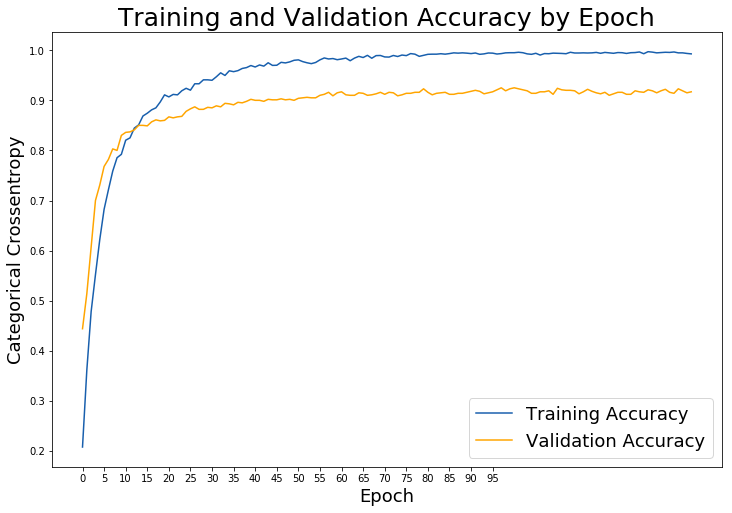

In [190]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [191]:
# Using our model to get the predictions for our test data
preds = model.predict_classes(X_test)

In [192]:
# Looking at our test data as a dataframe to be able to compare prediction values
test = data[4435:]

In [193]:
# Setting our predictions column
test['preds'] = preds

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [194]:
# Changing the prediction values to their actual labels
test['preds'] = test['preds'].map({8:'siren', 9:'street_music', 7:'jackhammer',
                   4:'drilling', 3:'dog_bark', 2:'children_playing',
                   6:'gun_shot', 5:'engine_idling', 0:'air_conditioner',
                   1:'car_horn'})

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [195]:
# Looking at how accurate our model is just by looking at it
test

,ID,Class,preds
4435,7136,gun_shot,gun_shot
4436,7137,siren,siren
4437,7138,jackhammer,jackhammer
4438,7140,drilling,drilling
4439,7141,air_conditioner,air_conditioner
...,...,...,...
5430,8725,engine_idling,engine_idling
5431,8726,dog_bark,dog_bark
5432,8727,engine_idling,engine_idling
5433,8728,engine_idling,engine_idling


In [196]:
# Slicing our dataframe into the files we got wrong from our predictions
test[test['Class']!=test['preds']]

,ID,Class,preds
4444,7148,siren,children_playing
4465,7178,drilling,dog_bark
4468,7185,children_playing,siren
4477,7200,dog_bark,children_playing
4519,7262,engine_idling,air_conditioner
...,...,...,...
5403,8685,drilling,street_music
5407,8694,street_music,drilling
5416,8709,dog_bark,children_playing
5420,8713,dog_bark,children_playing


In [197]:
# Calculating the actual test accuracy
round((1-len(test[test['Class']!=test['preds']])/len(test)),2)

0.93

### We got 93% accuracy in our test data

Saving the model to use in our voting classifier 

In [211]:
predic_nn = model.predict_proba(X_test)
predic_nn = pd.DataFrame(predic_nn)
predic_nn.to_csv('predict_nn.csv', index=False)